In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install keras==2.10.0
!pip install tensorflow==2.10.0
!pip install h5py==3.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#!unzip /content/drive/MyDrive/pcos_classification/Data.zip -d /content/drive/MyDrive/pcos_classification/Data

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display, clear_output
import ipywidgets as widgets
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
import itertools
from tensorflow.keras import layers ,models,optimizers
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam,SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Loading Data

In [6]:
labels = ['infected', 'notinfected']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150 #sizeof image

for label in labels:
    trainPath = os.path.join('/content/drive/MyDrive/pcos_classification/Data/train',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('/content/drive/MyDrive/pcos_classification/Data/test',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|██████████| 98/98 [00:01<00:00, 76.44it/s]


In [7]:
print(X_train.shape)
print(X_test.shape)

(1922, 150, 150, 3)
(196, 150, 150, 3)


In [8]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=10)
X_train.shape

(1922, 150, 150, 3)

Data Visualization

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


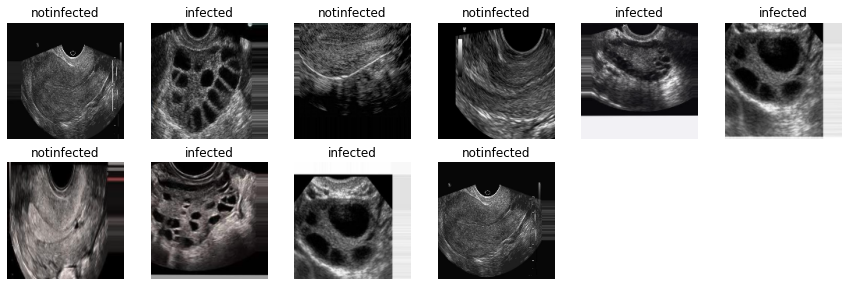

In [9]:
plt.figure(figsize=(15, 15))
class_names = Y_train
for i in range(0,10):
    for i in range(10):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(X_train[i])
        plt.title(Y_train[i])
        plt.axis("off")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


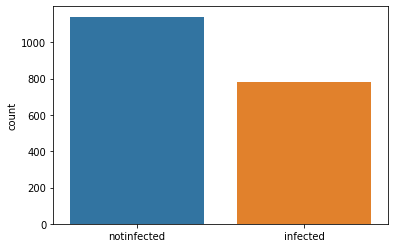

In [10]:
sns.countplot(Y_train)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


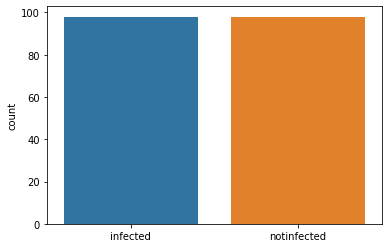

In [11]:
sns.countplot(Y_test)

In [12]:
#label encoding
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=28) #splitting data 

In [14]:
#Image augmentation
datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=30,
                             validation_split=0.3,
                             fill_mode='nearest'
                             )

In [15]:
batch_size = 32
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_val.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = datagen.flow(x_val, y_val, batch_size=batch_size)

1729
193



Resnet50

In [16]:
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [17]:
conv_model = resnet50.ResNet50(weights='imagenet',include_top=False,input_shape = (150,150,3))

for layer in conv_model.layers[:-3]:
    layer.trainable=False  #The role of the embedding layer is to map a category into a dense space in a way that is useful for the task

resnet_model = models.Sequential()
resnet_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_',input_shape = (150,150,3)))
resnet_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_2',padding = 'same'))
resnet_model.add(layers.Conv2D(32,(3,3),activation = 'relu',name = 'Conv_3',padding = 'same'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.MaxPooling2D((2,2),name = 'max_1'))
resnet_model.add(layers.Conv2D(64,(3,3),activation = 'relu',name = 'Conv_4',padding='same'))
resnet_model.add(layers.Conv2D(64,(3,3),activation = 'relu',name = 'Conv_5',padding='same'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.MaxPooling2D((2,2),name = 'max_2'))

resnet_model.add(layers.Conv2D(128,(3,3),activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.MaxPooling2D((2,2)))
resnet_model.add(layers.Conv2D(128,(3,3),activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512,activation = 'relu',name = 'L1',))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(256,activation = 'relu',name = 'L2'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(256,activation = 'relu',name = 'L3'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(128,activation = 'relu' ,name ='L4'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dense(2,activation = 'softmax',name = 'output'))

In [18]:
resnet_model.compile(optimizer = optimizers.SGD(learning_rate=.0001) ,
              loss='categorical_crossentropy',
              metrics=['acc'])

In [19]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv_ (Conv2D)              (None, 148, 148, 32)      896       
                                                                 
 Conv_2 (Conv2D)             (None, 148, 148, 32)      9248      
                                                                 
 Conv_3 (Conv2D)             (None, 148, 148, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 148, 148, 32)     128       
 ormalization)                                                   
                                                                 
 max_1 (MaxPooling2D)        (None, 74, 74, 32)        0         
                                                                 
 Conv_4 (Conv2D)             (None, 74, 74, 64)        18496     
                                                        

In [20]:
history1 = resnet_model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
54/54 [==============================] - 19s 252ms/step - loss: 0.7645 - acc: 0.6358 - val_loss: 0.7035 - val_acc: 0.5625
Epoch 2/5
54/54 [==============================] - 11s 197ms/step - loss: 0.6163 - acc: 0.7024 - val_loss: 0.8788 - val_acc: 0.5677
Epoch 3/5
54/54 [==============================] - 10s 193ms/step - loss: 0.4358 - acc: 0.7991 - val_loss: 1.1643 - val_acc: 0.5625
Epoch 4/5
54/54 [==============================] - 11s 194ms/step - loss: 0.3927 - acc: 0.8315 - val_loss: 1.3945 - val_acc: 0.5625
Epoch 5/5
54/54 [==============================] - 11s 204ms/step - loss: 0.2966 - acc: 0.8651 - val_loss: 1.5367 - val_acc: 0.5677


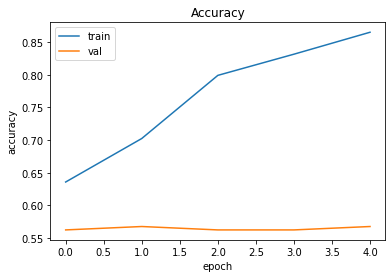

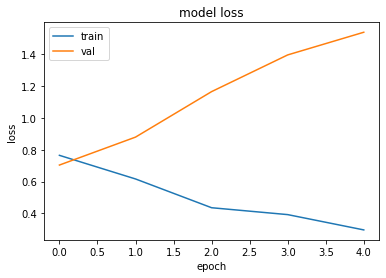

In [21]:
#accuracy and loss plot
plt.plot(history1.history['acc'])
plt.plot(history1.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#loss plot
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

7/7 [==============================] - 1s 66ms/step


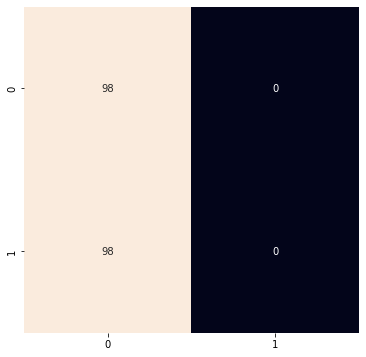

In [22]:
pred = resnet_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False);

In [23]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        98
           1       0.00      0.00      0.00        98

    accuracy                           0.50       196
   macro avg       0.25      0.50      0.33       196
weighted avg       0.25      0.50      0.33       196



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(2):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,sensitivity,specificity
0,0,0.0,1.0
1,1,1.0,0.0


EfficientNet- B2

In [25]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [26]:
model2 = base_model.output
model2 = GlobalAveragePooling2D()(model2)
model2 = Dropout(0.4)(model2)
model2 = Dense(2, activation='softmax')(model2)
model2 = Model(inputs = base_model.input, outputs=model2)

In [27]:
model2.compile(loss='categorical_crossentropy', optimizer=Adam(0.1), metrics=['accuracy'])

In [28]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 150, 150, 3)  0           ['normalization[0][0]']      

In [29]:
history2 = model2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
54/54 [==============================] - 35s 324ms/step - loss: 4.1743 - accuracy: 0.5527 - val_loss: 356240525885440.0000 - val_accuracy: 0.4375
Epoch 2/5
54/54 [==============================] - 15s 284ms/step - loss: 0.9573 - accuracy: 0.8556 - val_loss: 818050496.0000 - val_accuracy: 0.4323
Epoch 3/5
54/54 [==============================] - 13s 241ms/step - loss: 0.3443 - accuracy: 0.9582 - val_loss: 716211.7500 - val_accuracy: 0.4323
Epoch 4/5
54/54 [==============================] - 13s 243ms/step - loss: 0.1582 - accuracy: 0.9841 - val_loss: 94805.5078 - val_accuracy: 0.4375
Epoch 5/5
54/54 [==============================] - 13s 242ms/step - loss: 0.4870 - accuracy: 0.9605 - val_loss: 3275173.2500 - val_accuracy: 0.4375


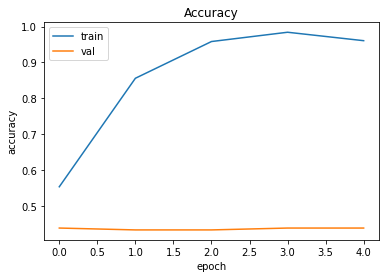

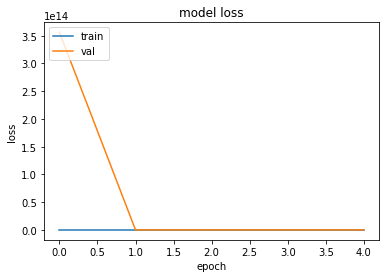

In [30]:
#accuracy and loss plot
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#loss plot
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

7/7 [==============================] - 3s 141ms/step


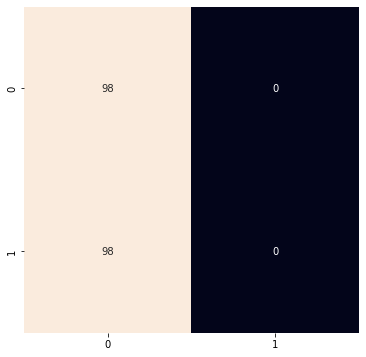

In [31]:
pred = model2.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False);

In [32]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        98
           1       0.00      0.00      0.00        98

    accuracy                           0.50       196
   macro avg       0.25      0.50      0.33       196
weighted avg       0.25      0.50      0.33       196



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(2):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,sensitivity,specificity
0,0,0.0,1.0
1,1,1.0,0.0


CNN Model

In [34]:
model = Sequential()
model.add(Conv2D(15, (5,5),padding='valid',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(5,5)))
model.add(Conv2D(12, (4,4),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Dropout(0.65))
model.add(Conv2D(8, (1,1),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size=(1,1)))
model.add(Dropout(0.55))
model.add(Flatten())
model.add(Dense(2,activation='softmax'))

In [35]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])


In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 146, 146, 15)      1140      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 15)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 12)        2892      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 12)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 12)          0         
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 8)          

In [37]:
history3 = model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 5, 
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/5
54/54 [==============================] - 14s 240ms/step - loss: 0.6927 - accuracy: 0.5692 - val_loss: 0.6824 - val_accuracy: 0.5677
Epoch 2/5
54/54 [==============================] - 9s 166ms/step - loss: 0.6740 - accuracy: 0.6205 - val_loss: 0.6504 - val_accuracy: 0.6354
Epoch 3/5
54/54 [==============================] - 9s 166ms/step - loss: 0.6074 - accuracy: 0.6694 - val_loss: 0.4780 - val_accuracy: 0.8281
Epoch 4/5
54/54 [==============================] - 9s 166ms/step - loss: 0.4733 - accuracy: 0.7784 - val_loss: 0.3313 - val_accuracy: 0.8698
Epoch 5/5
54/54 [==============================] - 9s 166ms/step - loss: 0.3088 - accuracy: 0.8869 - val_loss: 0.1703 - val_accuracy: 0.9635


In [38]:
model.save('/content/drive/MyDrive/pcos_classification/models/cnn.h5')

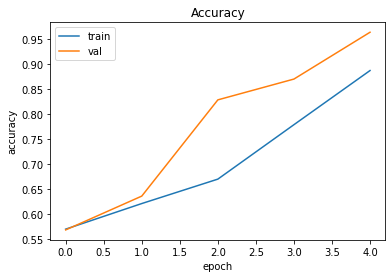

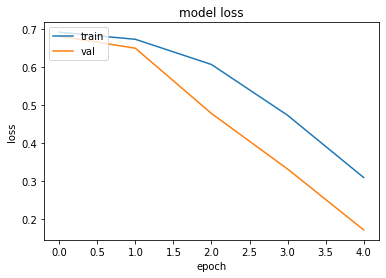

In [39]:
#accuracy and loss plot
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

#loss plot
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

7/7 [==============================] - 0s 15ms/step


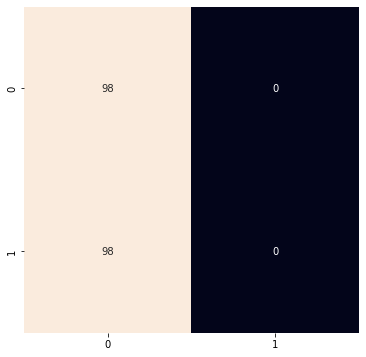

In [40]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

cmat = confusion_matrix(y_test_new,pred)
plt.figure(figsize=(6,6))
sns.heatmap(cmat, annot = True, cbar = False);

In [41]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        98
           1       0.00      0.00      0.00        98

    accuracy                           0.50       196
   macro avg       0.25      0.50      0.33       196
weighted avg       0.25      0.50      0.33       196



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
from sklearn.metrics import precision_recall_fscore_support
res = []
for l in range(2):
     prec,recall,_,_ = precision_recall_fscore_support(y_test_new==l,
                                                  pred==l,
                                                  pos_label=True,average=None)
     res.append([l,recall[0],recall[1]])

pd.DataFrame(res,columns = ['class','sensitivity','specificity'])

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,class,sensitivity,specificity
0,0,0.0,1.0
1,1,1.0,0.0
